**Flu Trends**

Applying the MultiOutput and Direct Strategies to the Flu Trends dataset and making true forecasts for multiple weeks beyond the training period. The forecast will have a 1-week lead time and an 8-week horizon. 

**Installing the libraries**


In [52]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter('ignore')

##Setting matplotlib defaults

plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('figure', autolayout = True, figsize = (11,4))
plt.rc(
    'axes',
    labelweight = 'bold',
    labelsize = 'large',
    titleweight = 'bold',
    titlesize = 16,
    titlepad = 10,)

plot_params = dict(color = '0.75', style = ".-", markeredgecolor = '0.25', markerfacecolor = '0.25')

%config InlineBackend.figure_format = 'retina'

In [53]:
#Defining the helper function, plot_multistep

def plot_multistep(y, every = 1, ax = None, palette_kwargs = None):
    
    palette_kwargs_ = dict(palette = 'husl', n_colors = 16, desat = None)
    
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    
    palette = sns.color_palette(**palette_kwargs_)

    if ax is None:
        fig, ax = plt.subplots()
    
    ax.set_prop_cycle(plt.cycler('color', palette)) #a color palette is set for the plot so each prediction series will have a different color

    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods = len(preds))
        preds.plot(ax=ax)
    return ax








In [54]:
#Reading the dataset and creating a pandas dataframe

flu_trends = pd.read_csv('/workspaces/Projects/Time Series Forecasting/Data&Files/Data/flu-trends.csv')
flu_trends.set_index(
pd.PeriodIndex(flu_trends.Week, freq = 'W'),
inplace = True
)

flu_trends.drop('Week', axis = 1, inplace = True)

In [55]:
#Preparing target series(weekly office visits for the flu) for multistep forecasting

def make_lags(ts, lags, lead_time = 1):
    return pd.concat(
        {f'y_lag{i}':ts.shift(i)
         for i in range(lead_time, lags+lead_time)

    }, axis = 1)


#Four weeks of lag features

y = flu_trends.FluVisits.copy()
X = make_lags(y, lags = 4).fillna(0.0)

def make_multistep_target(ts,steps):
    return pd.concat(
        {f'y_step{i}' : ts.shift(-i) for i in range(steps)}, axis = 1
    )

#Eight week forecast

y = make_multistep_target(y, steps = 8). dropna()


#Shifting has created the indices that do not match. Performing an inner join to retain the times for which we have both target and values

y, X = y.align(X, join = 'inner', axis = 0)

**Multioutput Model**

Using linear regression as a MultiOutput strategy

In [56]:
#Creating splits

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

A multistep model will produce a complete forecast for each instance used as an input. There are 269 weeks in the training set and 90 weeks in the test set. We now have a 8 week forecast for each of these weeks. 

Train_RMSE:389.12
Test_RMSE:582.33


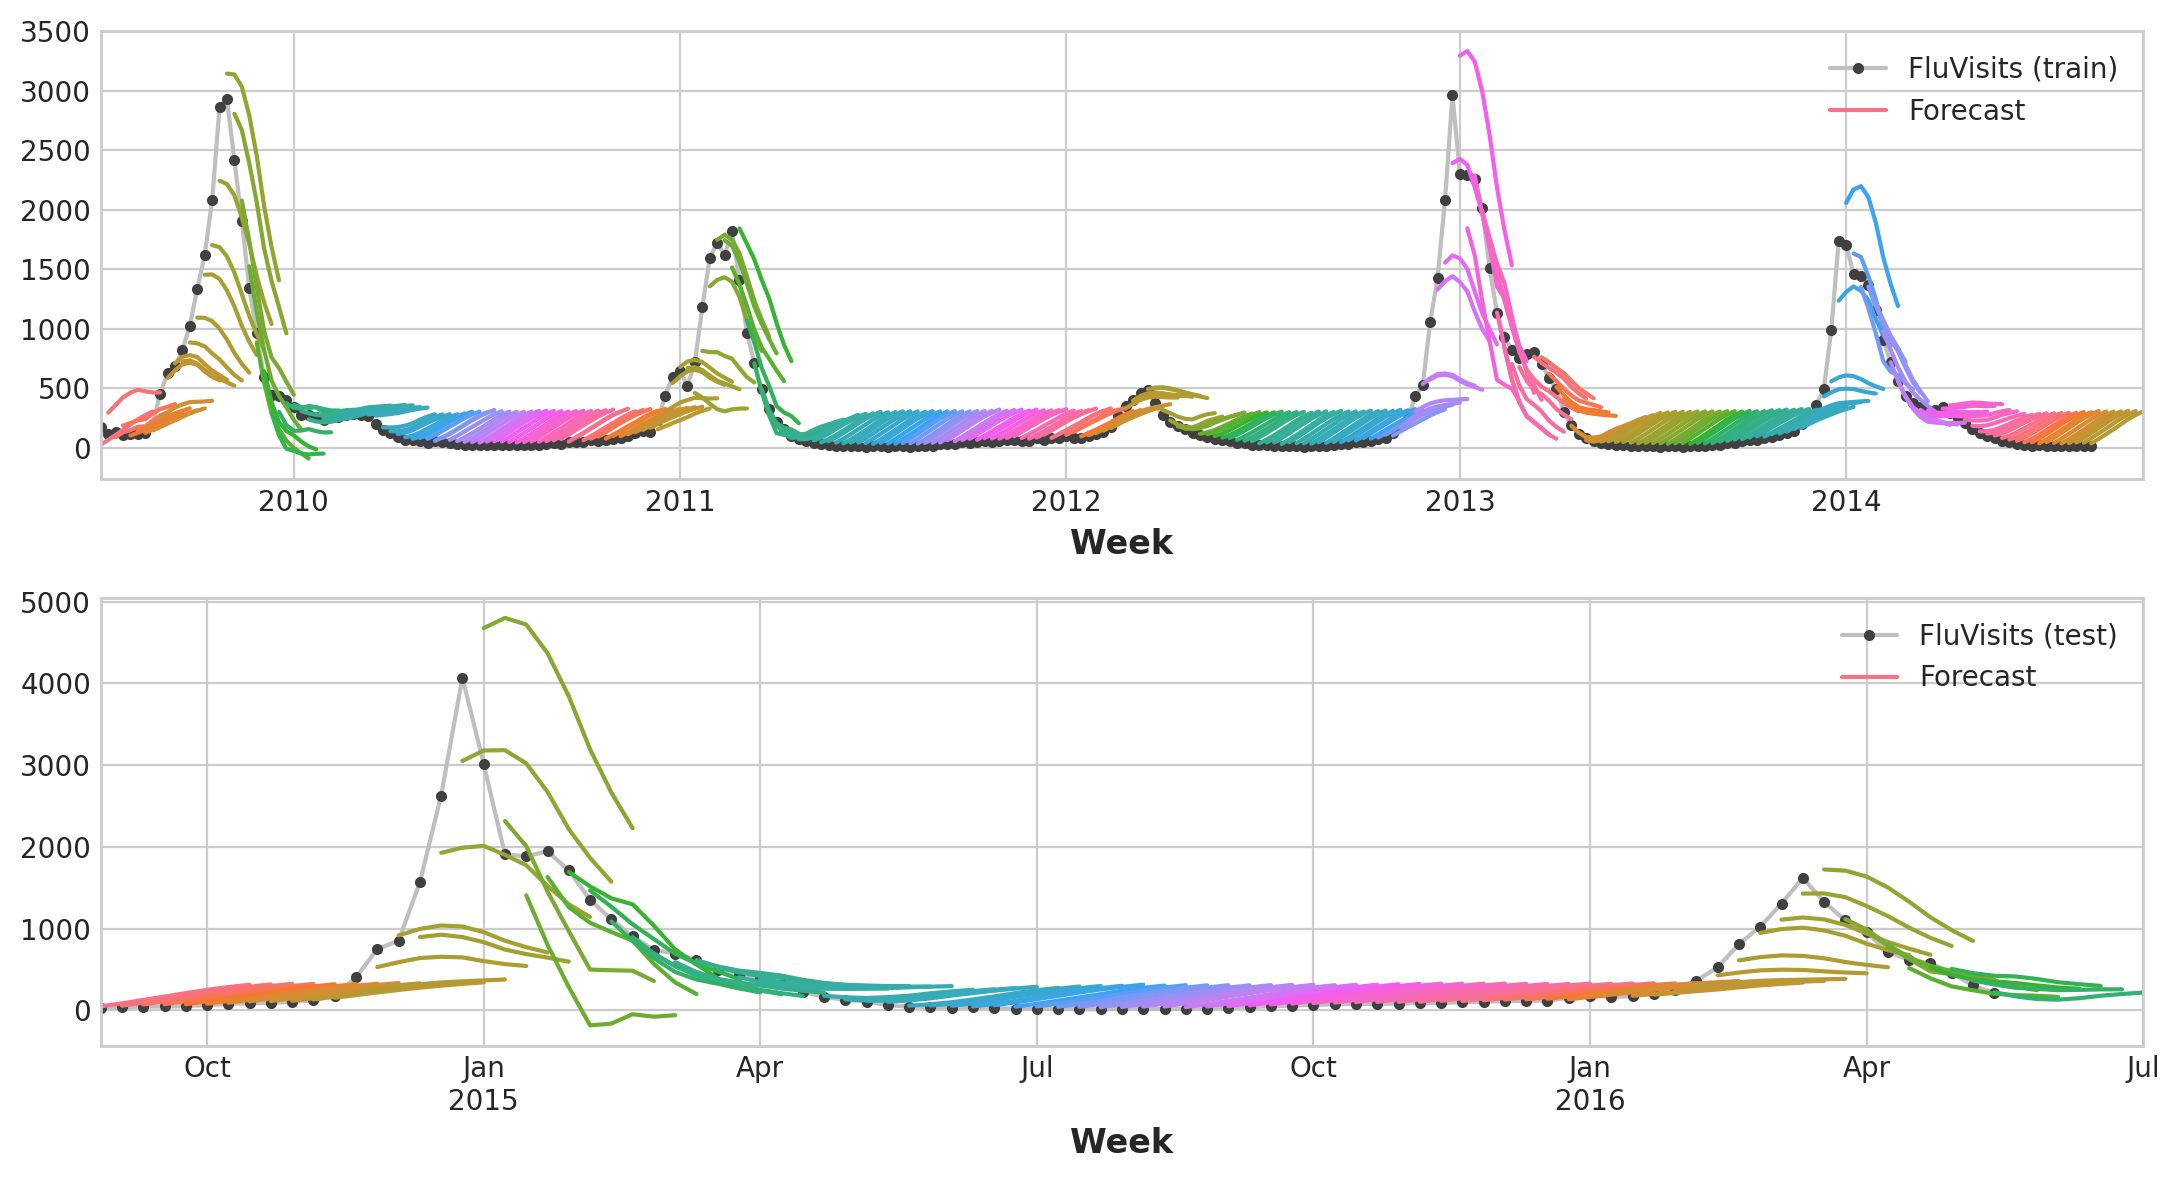

In [57]:
train_rmse = mean_squared_error(y_train, y_fit, squared = False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print (f"Train_RMSE:{train_rmse:.2f}\n" f"Test_RMSE:{test_rmse:.2f}")

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

**Direct Strategy**

XGBoost cannot produce multiple outputs for regression tasks. But by applying the Direct Reduction Strategy, we can still use it to produce multi-step forecasts. It can be achieved by wrapping XGBoost with MultiOutputRegressor. 